Las cuatro redes de proteínas de levadura que
disponemos: Y2H, AP-MS, LIT y Lit-Reguly. Las dos últimas son redes construidas a partir de
interacciones reportadas en la literatura. 

In [1]:
#librerias a utilizar
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as scipy

In [2]:
#Para abrir archivos
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    if os.path.basename(nombre_archivo) == 'yeast_LIT_Reguly.txt':
        data = data[1:]
        enlaces = []
        for linea in data:
            enlaces.append(linea[:2])
        return(enlaces)
    if os.path.basename(nombre_archivo) == 'Essential_ORFs_paperHe.txt': 
        data = data[2:]
        esenciales = []
        for linea in data:
            if len(linea)>2:
                esenciales.append(linea[1])
        return esenciales
    else:
        return data

def crear_redes(red):
    lista_de_enlaces = abrir_txt(red)
    Red = nx.Graph()
    Red.add_edges_from(lista_de_enlaces)
    return Red

In [3]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'AP_MS': './data/yeast_AP-MS.txt',
         'Lit': './data/yeast_LIT.txt',
         'Lit_reg': "./data/yeast_LIT_Reguly.txt"
         }
redes_dict = {}

for red in redes:
    grafo = crear_redes(redes[red])
    redes_dict[red] = {}
    redes_dict[red]["Grafo"] = grafo

# Tabla 1

In [4]:
def get_red_info(nombre_red):
    
    red = redes_dict[nombre_red]
    grafo = red['Grafo']
    red['Nodos'] = grafo.number_of_nodes() 
    red['Enlaces'] = grafo.number_of_edges()
    red['Grado medio'] = 2 * red['Enlaces'] / red['Nodos']
    red['Clustering medio'] = nx.average_clustering(grafo)   

In [5]:
for red in redes_dict.keys():
    get_red_info(red)

In [18]:
import pandas as pd

redes_df = redes_dict.copy() #no modificar data
df = pd.DataFrame(redes_dict).transpose()
df_sin_grafo = df.drop(columns = ['Grafo'])
df_sin_grafo = df_sin_grafo.astype({'Clustering medio': float, 'Grado medio': float})
df_sin_grafo.round({'Clustering medio': 2, 'Grado medio': 2})

,Clustering medio,Enlaces,Grado medio,Nodos
Y2H,0.05,2930,2.90,2018
AP_MS,0.55,9070,11.18,1622
Lit,0.29,2925,3.81,1536
Lit_reg,0.26,11858,7.17,3307


# Tabla 2

In [6]:
nodos = {}
enlaces = {}

for red in redes_dict:
    Red_proteinas = redes_dict[red]['Grafo']
    #Guardo enlaces y nodos en un set para poder hacer comparaciones facilmente
    enlaces[red], nodos[red] = set(), set()
    for nodo in Red_proteinas.nodes(): nodos[red].add(nodo)
    #Como los enlaces son NO dirigidos, los ordeno los nodos del enlace antes de guardarlo
    for enlace in Red_proteinas.edges(): enlace=sorted(enlace);enlaces[red].add((enlace[0],enlace[1]))

In [20]:
overlap_dict = {}  
lista_redes = list(redes_dict.keys())
lista_redes

['Y2H', 'AP_MS', 'Lit', 'Lit_reg']

In [38]:
def intersection(dicts):
    for key in dicts.keys():
        overlap_dict[key] = {}
        overlap_dict[key][key] = 0
        a = dicts[key]
        lista = ('b', 'c', 'd')
        for red in dicts.keys():
            if red == key:
                overlap_dict[key][key] = 0 
            else:
                interseccion = a.intersection(dicts[red])
                overlap_dict[key][red] = len(interseccion) / len(a)
            
                           
intersection(enlaces)     

In [39]:
overlap_dict

{'Y2H': {'Y2H': 0,
  'AP_MS': 0.08873720136518772,
  'Lit': 0.08873720136518772,
  'Lit_reg': 0.163481228668942},
 'AP_MS': {'AP_MS': 0,
  'Y2H': 0.02866593164277839,
  'Lit': 0.14310915104740904,
  'Lit_reg': 0.27783902976846747},
 'Lit': {'Lit': 0,
  'Y2H': 0.08888888888888889,
  'AP_MS': 0.4437606837606838,
  'Lit_reg': 0.9777777777777777},
 'Lit_reg': {'Lit_reg': 0,
  'Y2H': 0.040394670264800134,
  'AP_MS': 0.21251475796930341,
  'Lit': 0.24118738404452691}}

In [40]:
enlaces_df = overlap_dict.copy() #no modificar data
df = pd.DataFrame(enlaces_df).transpose()
df = df.astype(float).round(3)
for red, _ in df.iterrows():
    df.loc[df[red] == 0, red] = '-'
df


,AP_MS,Lit,Lit_reg,Y2H
Y2H,0.089,0.089,0.163,-
AP_MS,-,0.143,0.278,0.029
Lit,0.444,-,0.978,0.089
Lit_reg,0.213,0.241,-,0.04


Esta tabla se lee "De los enlaces de Y2H un 8.9% de sus enlaces también está en AP MS".

Esto no lo pide, pero podriamos ponerlo. Lo mismo una tabla para nodos. 

In [41]:
from venn import venn
f, axs = plt.subplots(1, 2 , figsize=(15,15))
venn_e = venn(enlaces, fmt="{percentage:.1f}%", ax= axs[0], cmap = "plasma")
axs[0].set_title("Enlaces")
venn(nodos, fmt="{percentage:.1f}%", ax= axs[1] )
axs[1].set_title("Nodos")
plt.show()

ModuleNotFoundError: No module named 'venn'

# Figura 1

In [7]:
lista_esenciales = abrir_txt('./data/Essential_ORFs_paperHe.txt')

grados_ordenados = {}

def segundo_lugar(item):
    return item[1]

for red in redes_dict.keys():
    grados_lista = list(redes_dict[red]['Grafo'].degree())
    grados_lista.sort(key = segundo_lugar, reverse = True)
    grados_ordenados[red] = grados_lista

In [43]:
from operator import itemgetter

def calcular_esenciales(red):
    
    nodos = list(map(itemgetter(0), grados_ordenados[red])) #lista de nodos ordenados por grado
    orden_grados = list(map(itemgetter(1), grados_ordenados[red])) #grados de dichos nodos
    
    hub_definition = []
    fraccion_hubs_esenciales = []

    for i in orden_grados: 
        lista_nodos = []
        for j in range(0,len(nodos)):
            if orden_grados[j] >= i: 
                lista_nodos.append(nodos[j]) #solo si tienen mayor grado
        
        hub_definition.append(len(lista_nodos) / redes_dict[red]['Nodos']) #propocion de nodos que tomo como hub
        hubs_esenciales = set(lista_nodos).intersection(lista_esenciales) #nodos esenciales dentro de los hubs
        fraccion_hubs_esenciales.append(len(hubs_esenciales) / len(lista_nodos) ) #fraccion entre los hubs de esenciales       
        
    return hub_definition, fraccion_hubs_esenciales

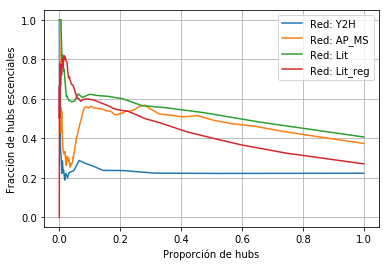

In [44]:
correlaciones = {}
for red in redes_dict.keys():
    x, y = calcular_esenciales(red)
    correlaciones[red] = {}
    correlaciones[red]['Kendall'] = scipy.kendalltau(x,y)[0]
    correlaciones[red]['Kendall p value'] = (scipy.kendalltau(x,y)[1])
    correlaciones[red]['Spearman'] = scipy.spearmanr(x,y)[0]
    correlaciones[red]['Spearman p value'] = scipy.spearmanr(x,y)[1]
    plt.plot(x, y, label = f'Red: {red}')
    plt.xlabel('Proporción de hubs')
    plt.ylabel('Fracción de hubs escenciales')
    plt.legend()
    

plt.grid()
plt.show()

In [45]:
correlaciones_df = correlaciones.copy() #no modificar data
df = pd.DataFrame(correlaciones_df).transpose()
df = df.astype(float).round(3)
df

,Kendall,Kendall p value,Spearman,Spearman p value
Y2H,-0.351,0.0,-0.448,0.0
AP_MS,-0.689,0.0,-0.693,0.0
Lit,-0.971,0.0,-0.994,0.0
Lit_reg,-0.995,0.0,-0.998,0.0


# Figura 3

Esto es igualito al ejercicio 2c del TPC_01.
Tenemos que considerar 7 centralidades:
* Remover nodos esenciales de una
* Random (ver código ya hecho)
* Eigenvalue: diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
* Degree centrality diccionario_centralidad_grado = nx.degree_centrality(Red)
* Shortest path diccionario_centralidad_intermediatez = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
* current_flow 
* diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)
*

### 1) Esenciales

In [46]:
def sacar_esenciales(red, lista_esenciales):
    cant_nodos = redes_dict[red]['Nodos']
    Graph = redes_dict[red]['Grafo'].copy() #no modifico originales
    Graph.remove_nodes_from(lista_esenciales)
    fracc_nodos_sacados = 1 - Graph.number_of_nodes() / cant_nodos
      
    
    componentes=[Graph.subgraph(componente)
                 for componente in sorted(nx.connected_components(Graph),
                                          key=len, reverse=True)]
    gigante = componentes[0]
    fracc_tamamo_gigante = gigante.number_of_nodes() / cant_nodos
    return fracc_nodos_sacados, fracc_tamamo_gigante

Esto sólo para saber

In [47]:
nodos_esenciales_frac = {}
for red in redes_dict.keys():
    nodos_esenciales_frac[red] = len(set(redes_dict[red]["Grafo"].nodes()).intersection(lista_esenciales)) / redes_dict[red]['Nodos']

nodos_esenciales_frac

{'Y2H': 0.22348860257680872,
 'AP_MS': 0.37422934648581996,
 'Lit': 0.4069010416666667,
 'Lit_reg': 0.27094042939219837}

Ploteo para ir viendo, pero después hacemos toda una figura

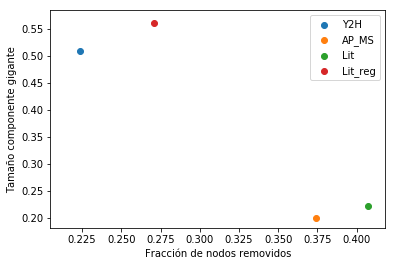

In [48]:
x_esen = {}
y_esen = {}

for red in redes_dict.keys():
    x_esen[red], y_esen[red] = sacar_esenciales(red, lista_esenciales)
    plt.scatter(x_esen[red], y_esen[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 2) Random

In [49]:
def desarme_random(red):
    cant_nodos = redes_dict[red]['Nodos']
    tamano_gigante = np.array([])
    Red_rota_rand = redes_dict[red]['Grafo'].copy()
    nodes = list(Red_rota_rand.nodes)
    
    for node in nodes:
        Red_rota_rand.remove_node(node)
        componentes  = sorted(nx.connected_components(Red_rota_rand), 
                                                   key=len, reverse=True)
        
                        
        if len(componentes) >= 1:
            gigante = Red_rota_rand.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
            
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

In [50]:
import time

times = 2
i = 0
y_rand = {k: np.zeros(shape = redes_dict[k]["Nodos"]) for k in redes_dict.keys()}

while i < times:
    for red in redes_dict.keys():
        start = time.time()
        y_rand[red] = y_rand[red] + desarme_random(red)
        end = time.time()
        print(f'La red {red}_{i} tardó {round(end - start, 2)}s')
    i += 1

La red Y2H_0 tardó 12.1s
La red AP_MS_0 tardó 7.53s
La red Lit_0 tardó 6.85s
La red Lit_reg_0 tardó 34.69s
La red Y2H_1 tardó 11.66s
La red AP_MS_1 tardó 7.47s
La red Lit_1 tardó 6.97s
La red Lit_reg_1 tardó 33.87s


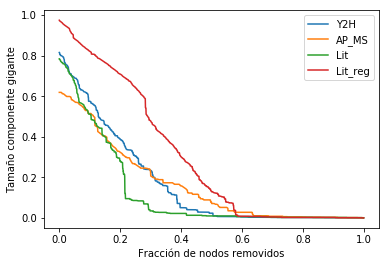

In [51]:
for red in y_rand.keys():
    y = y_rand[red] / times
    cant_nodos = redes_dict[red]['Nodos']
    x = [x / cant_nodos for x in range(0, len(y))]
    plt.plot(x,y, label = f'{red}')
    
plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 3) Eigenvalue

In [52]:
import operator

def desarme_eigenvalue(red):
    centrality = nx.eigenvector_centrality(redes_dict[red]["Grafo"], max_iter=1000, tol=1e-03)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(centrality.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        centrality = nx.eigenvector_centrality(Red_rota, max_iter=1000, tol=1e-03)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

In [53]:
x_eigen = {}
y_eigen = {}

for red in redes_dict.keys():
    y_eigen[red] = desarme_eigenvalue(red)
    x_eigen[red] = [x / cant_nodos for x in range(0, len(y_eigen[red]))]
    plt.plot(x_eigen[red], y_eigen[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

KeyboardInterrupt: 

### 4) Degree

In [ ]:
import operator

def desarme_degree(red):
    degree = nx.degree_centrality(redes_dict[red]["Grafo"])

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > 1:
        node = max(degree.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
        
        #print(Red_rota.number_of_nodes())
        degree = nx.degree_centrality(Red_rota)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

In [ ]:
x_deg = {}
y_deg = {}

for red in redes_dict.keys():
    y_deg[red] = desarme_degree(red)
    x_deg[red] = [x / cant_nodos for x in range(0, len(y_deg[red]))]
    plt.plot(x_deg[red], y_deg[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 5) Betweeness

In [ ]:
import operator

def desarme_bet(red):
    k = 20
    bet = nx.betweenness_centrality(redes_dict[red]["Grafo"], k = k)

    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()

    while Red_rota.number_of_nodes() > k:
        node = max(bet.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)
       
        bet = nx.betweenness_centrality(Red_rota, k = k)
        componentes  = sorted(nx.connected_components(Red_rota), 
                                                   key=len, reverse=True)
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0]) 
            tamano_gigante = np.append(tamano_gigante, gigante.number_of_nodes() / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante

In [ ]:
x_bet = {}
y_bet = {}

for red in redes_dict.keys():
    start = time.time()
    y_bet[red] = desarme_bet(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x_bet[red] = [x / cant_nodos for x in range(0, len(y_bet[red]))]
    plt.plot(x_bet[red], y_bet[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

### 6) Closeness

In [ ]:
import igraph as ig

def close_ig(red):
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(list(red.nodes()))
    G_ig.add_edges(list(red.edges()))
    conectado = G_ig.components()[0]
    component = G_ig.subgraph(conectado)
    closeness = component.closeness(vertices=None, mode='ALL', cutoff=None, weights=None, normalized=True)
    keys = list(red.nodes())
    close_dict = dict(zip(keys, closeness))
    return close_dict



In [ ]:
import operator

def desarme_close(red):

    close = close_ig(redes_dict[red]['Grafo'])
       
    tamano_gigante = []
    Red_rota = redes_dict[red]['Grafo'].copy()
    
    i = 0
    size_gigante = redes_dict[red]['Nodos']
    
    while 1 <  Red_rota.number_of_nodes():
        node = max(close.items(), key=operator.itemgetter(1))[0]
        Red_rota.remove_node(node)

        close = close_ig(Red_rota)
        componentes = sorted(nx.connected_components(Red_rota), key=len, reverse=True)
        i += 1                                                   
                                       
        if len(componentes) >= 1:
            gigante = Red_rota.subgraph(componentes[0])
            size_gigante = gigante.number_of_nodes()
            tamano_gigante = np.append(tamano_gigante, size_gigante / cant_nodos )
    
    tamano = np.size(tamano_gigante)        
    tamano_gigante = np.pad(tamano_gigante, (0, cant_nodos - tamano ), 'constant')

    return tamano_gigante 
     

In [ ]:
x_clos = {}
y_clos = {}

for red in redes_dict.keys():
    start = time.time()
    y_clos[red] = desarme_close(red)
    end = time.time()
    print(f'La red {red} tardó {round(end - start, 2)}s')
    x_clos[red] = [x / cant_nodos for x in range(0, len(y_clos[red]))]
    plt.plot(x_clos[red], y_clos[red], label = f'{red}')

plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño componente gigante")
plt.legend()
plt.show()

# En un plot para cada una

KeyError: 'Y2H'

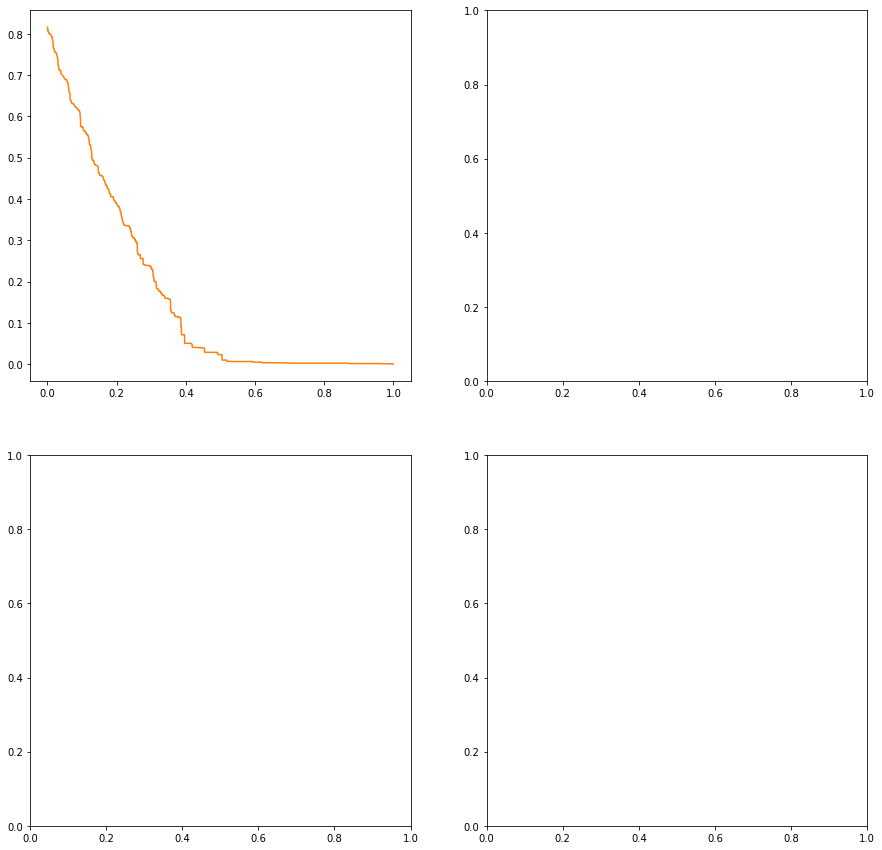

In [54]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

for i,red in enumerate(redes_dict.keys()):
#esen
    ax[i].plot(x_esen[red], y_esen[red], label = 'Esenciales')

#rand
    y = y_rand[red] / times
    cant_nodos = redes_dict[red]['Nodos']
    x = [x / cant_nodos for x in range(0, len(y))]
    
    ax[i].plot(x, y, label = 'Random')
    
#eigen
    ax[i].plot(x_eigen[red], y_eigen[red], label = 'Eigenvalue')

#degree
    ax[i].plot(x_deg[red], y_deg[red], label = 'Degree')

#Betweenness
    ax[i].plot(x_bet[red], y_bet[red], label = 'Betweenness')

#Closeness
    ax[i].plot(x_clos[red], y_clos[red], label = 'Closeness')

    ax[i].legend()
    ax[i].set_title(f'Desarme de la red {red}')
    ax[i].set_xlabel("Fracción de nodos removidos")
    ax[i].set_ylabel("Tamaño componente gigante")
    plt.grid()
plt.savefig(f'{red}.png')
plt.show()

## Figura 2.b

In [8]:
import time

def IBEP(red,lista_esenciales): #calcula el numero de interacciones entre nodos esenciales
    interacciones_nodos_esenciales = len(red.edges(lista_esenciales))
    return interacciones_nodos_esenciales

def recableado_IBEPs(red,num_recableos):
    Red = redes_dict[red]['Grafo'].copy()
    lista_IBEP = []
    for i in range(num_recableos): #la recableo n veces:
        start = time.time()
        Red_recableada = nx.algorithms.smallworld.random_reference(Red, niter=1, connectivity=True, seed=None)
        end = time.time()
        print(f'El recableo de la red {red} tardó {round(end - start, 2)}s')
        IBEPs = IBEP(Red_recableada,lista_esenciales) #calcula el numero de IBEP
        lista_IBEP.append(IBEPs)
    return lista_IBEP

def alfa(red,media_recableado,IBPs_original): #definicion del alfa del paper
    frac_int_esenciales = (IBEPs_original - media_recableado) / len(redes_dict[red]['Enlaces'])
    return frac_int_esenciales
    
def beta(red,lista_esenciales):
    frac_nodos_esenciales = len(lista_esenciales)/len(redes_dict[red]['Nodos'])
    return frac_nodos_esenciales

El recableo de la red Y2H tardó 249.7s
El recableo de la red Y2H tardó 236.8s
El recableo de la red Y2H tardó 234.89s
El recableo de la red Y2H tardó 224.37s
El recableo de la red Y2H tardó 231.81s
El recableo de la red Y2H tardó 260.19s
El recableo de la red Y2H tardó 297.01s
El recableo de la red Y2H tardó 309.78s
El recableo de la red Y2H tardó 302.61s
El recableo de la red Y2H tardó 284.06s


NameError: name 'IBEPs_original' is not defined

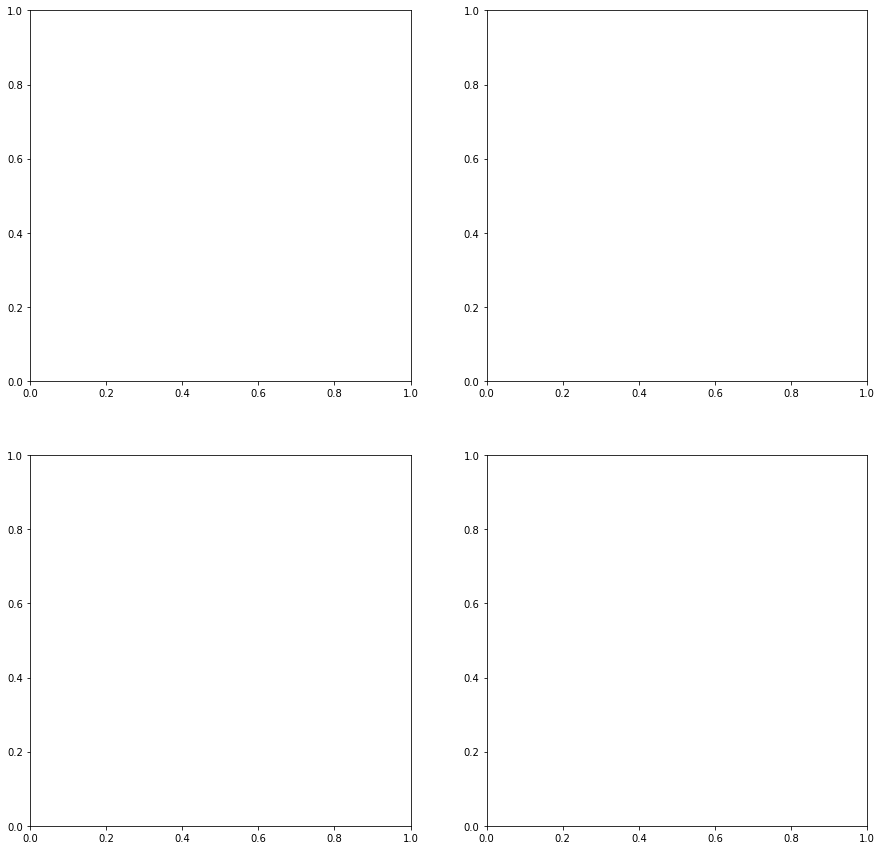

In [10]:
from statistics import mean 

fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()
lista_alfa = []
lista_beta = []
lista_IBEPs_original = []
lista_media_recableado = []

for i,red in enumerate(redes_dict.keys()):
    n = 1000
    lista_recableado = recableado_IBEPs(red,n) #recableo 1000 veces. Ideal seria 10.000 como en el paper
    
    #busco los valores que necesito
    media_recableado = mean(lista_recableado)
    IBEPs_original = (IBEP(redes_dict[red]['Grafo'],lista_esenciales))
    alfa_red = alfa(red,media_recableado,IBEPs_original)
    beta_red = beta(red,lista_esenciales)
    
    #los guardo en listas
    lista_beta.append(beta_red)
    lista_alfa.append(alfa_red)
    lista_IBEPs_original.append(IBEPs_original)
    lista_media_recableado.append(alfa_red)
    
    #grafico
    ax[i].hist(lista_recableado)
    ax[i].set_xlabel('Cantidad de IBEPs')
    ax[i].set_ylabel('Frecuencia')
    ax[i].set_title(f'Histograma correspondiente a {n} recableados')
    ax[i].set_axvline(IBEPs_original, label = 'Red original')
    
plt.legend()
plt.show()

0


NameError: name 'lista_alfa' is not defined

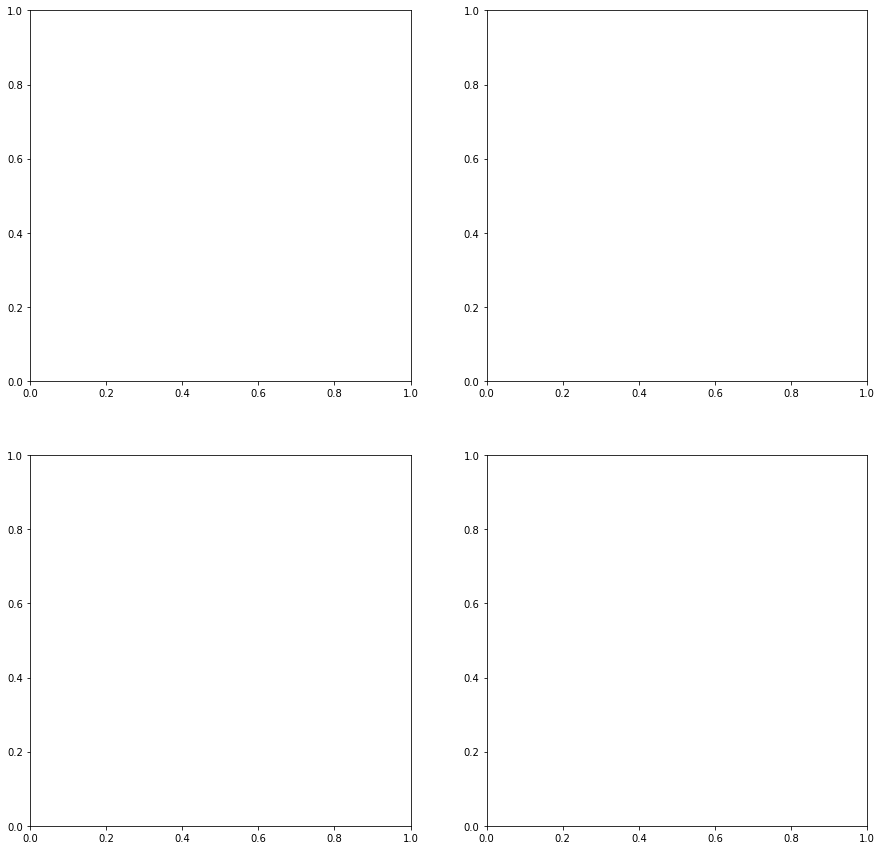

In [28]:
#definimo P_e a la probailidad de que una proteina sea esencial

def P_e_linealizada(alfa,beta,k):
    return k*np.log(1-alfa) + np.log(1-beta)

#ploteamos 

fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

for i,red in enumerate(redes_dict.keys()):
    print(nx.node_connectivity(redes_dict['Y2H']['Grafo']))
    ks = np.arange(10)
    Pe_lin = P_e_linealizada(lista_alfa[i],lista_beta[i],ks)
    ax[i].scatter(ks,Pe_lin)
    ax[i].set_xlabel('Conectividad (k)')
    ax[i].set_ylabel('ln(1-P_e)')
    ax[i].set_title(f'Probabilidad de que un nodo sea esencial red {red}')
plt.show()
    
    
    